# Bank Customer Churn Prediction

## 1. Problem description and EDA procedure

**This project focuses on the prediction of bank customer churn using machine learning models. The aim of the project is to help banks improve their customer loyalty.**

**The dataset is from Kaggle. Data source: https://www.kaggle.com/datasets/shubhammeshram579/bank-customer-churn-prediction**

**The EDA process involves the following steps:**

   **Data Cleaning**: 
   - Handling missing values 
   - Removing duplicates

   **Data Preprocessing**: 
   - Categorical feature encoding 
   - Numerical feature scaling 
   - Checking feature correlation

   **Model Selection and Comparison**: 
   - Building a baseline model
   - Improving baseline model by handling imbalanced target data
   - Comparing different models with hyperparameter tuning



## 2. Load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from category_encoders import TargetEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from tabulate import tabulate


In [2]:
data = pd.read_csv('dataset/Churn_Modelling.csv')
data.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10002 non-null  int64  
 1   CustomerId       10002 non-null  int64  
 2   Surname          10002 non-null  object 
 3   CreditScore      10002 non-null  int64  
 4   Geography        10001 non-null  object 
 5   Gender           10002 non-null  object 
 6   Age              10001 non-null  float64
 7   Tenure           10002 non-null  int64  
 8   Balance          10002 non-null  float64
 9   NumOfProducts    10002 non-null  int64  
 10  HasCrCard        10001 non-null  float64
 11  IsActiveMember   10001 non-null  float64
 12  EstimatedSalary  10002 non-null  float64
 13  Exited           10002 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 1.1+ MB


In [4]:
data.drop(columns = ['CustomerId', 'RowNumber'], inplace = True)

## 3. Data cleaning and preprocessing

A few steps were undertaken in the data cleaning and preprocessing phase, including handling missing value and duplicates, encoding categorical features, as well as scaling numerical features. Visualization was used to inspect the data distributions, in order to help identify the most suitable scaling method for numerical features. Additionally, feature correlation was evaluated through correlation matrix to address any highly correlated feature pairs that might need to be removed to avoid muliticollinearity.



### 3.1 Missing value


In [5]:
data.isna().sum()/len(data)

Surname            0.0000
CreditScore        0.0000
Geography          0.0001
Gender             0.0000
Age                0.0001
Tenure             0.0000
Balance            0.0000
NumOfProducts      0.0000
HasCrCard          0.0001
IsActiveMember     0.0001
EstimatedSalary    0.0000
Exited             0.0000
dtype: float64

In [6]:
data.dropna(inplace = True)


#### Since the percentage of missing data is only 0.1%, the affected rows were dropped.

### 3.2 Duplicates

In [7]:
duplicate_count = data.duplicated().sum()
duplicate_count

2

In [8]:
data.drop_duplicates(inplace = True)

### 3.3 Encode categorical features

In [9]:
categorical_features = data.select_dtypes(include = ['object']).columns.tolist()
data[categorical_features].nunique()

Surname      2932
Geography       3
Gender          2
dtype: int64

In [10]:
## check the correlation between 'Surname' and target 'Exited'
target_encoder = TargetEncoder(cols='Surname')
data['Surname_encoded'] = target_encoder.fit_transform(data['Surname'], data['Exited'])
data.drop('Surname', axis=1, inplace=True)

corr = data[['Surname_encoded', 'Exited']].corr(method='spearman')
print(corr)

                 Surname_encoded    Exited
Surname_encoded         1.000000  0.435218
Exited                  0.435218  1.000000


##### The result shows that there is a positive, moderate association between the encoded surname and the likelihood of a customer exiting. 

In [11]:
X = data.drop(columns = ['Exited'])
y = data['Exited']

In [12]:
# Onehot encoding is used in features 'Geography' and 'Gender', due to small number of unique categories
X_cleaned = pd.get_dummies(X, columns=['Geography', 'Gender'], drop_first=True)
X_cleaned.head(10)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Surname_encoded,Geography_Germany,Geography_Spain,Gender_Male
0,619,42.0,2,0.00,1,1.0,1.0,101348.88,0.307376,0,0,0
1,608,41.0,1,83807.86,1,0.0,1.0,112542.58,0.167126,0,1,0
2,502,42.0,8,159660.80,3,1.0,0.0,113931.57,0.214480,0,0,0
3,699,39.0,1,0.00,2,0.0,0.0,93826.63,0.207504,0,0,0
5,645,44.0,8,113755.78,2,1.0,0.0,149756.71,0.166713,0,1,1
7,376,29.0,4,115046.74,4,1.0,0.0,119346.88,0.245800,1,0,0
10,528,31.0,6,102016.72,2,0.0,0.0,80181.12,0.177268,0,0,1
11,497,24.0,3,0.00,2,1.0,0.0,76390.01,0.163470,0,1,1
12,476,34.0,10,0.00,2,1.0,0.0,26260.98,0.166607,0,0,0
13,549,25.0,5,0.00,2,0.0,0.0,190857.79,0.197248,0,0,0


### 3.4 Data scaling

Based on the distribution of numerical features, different scaling approach has been used.

CreditScore: Mean 650, Median 652, Mode 850
Age: Mean 38, Median 37, Mode 37
Tenure: Mean 5, Median 5, Mode 2
Balance: Mean 76476, Median 97173, Mode 0
NumOfProducts: Mean 1, Median 1, Mode 1
EstimatedSalary: Mean 100106, Median 100238, Mode 24924


<Figure size 1400x1000 with 0 Axes>

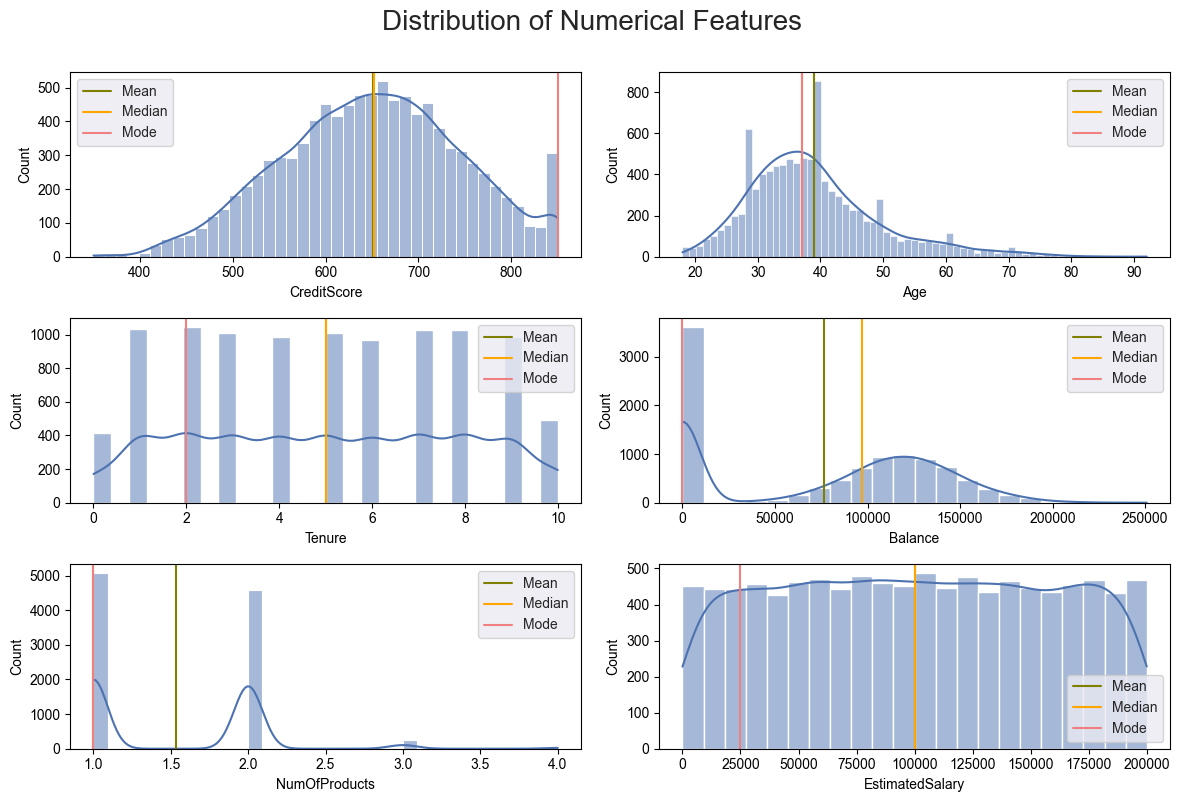

In [13]:
## check the distribution of numerical features with histplots
num_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

plt.figure(figsize=(14, 10))
fig, axs = plt.subplots(3, 2, figsize=(12, 8))

for i, feature in enumerate(num_features):
    row = i // 2
    col = i % 2
    sns.set_theme(style="darkgrid")
    sns.histplot(data=X_cleaned, x=feature, kde=True, ax=axs[row, col])
    axs[row, col].axvline(X_cleaned[feature].mean(), color='olive', label='Mean')
    axs[row, col].axvline(X_cleaned[feature].median(), color='orange',label='Median')
    axs[row, col].axvline(X_cleaned[feature].mode()[0], color='lightcoral', label='Mode')
    axs[row, col].legend(loc='best', fontsize=10)
    print(f'{feature}: Mean {int(X_cleaned[feature].mean())}, Median {int(X_cleaned[feature].median())}, Mode {int(X_cleaned[feature].mode()[0])}')

plt.suptitle("Distribution of Numerical Features", fontsize=20, y=1)
plt.tight_layout()
plt.show()


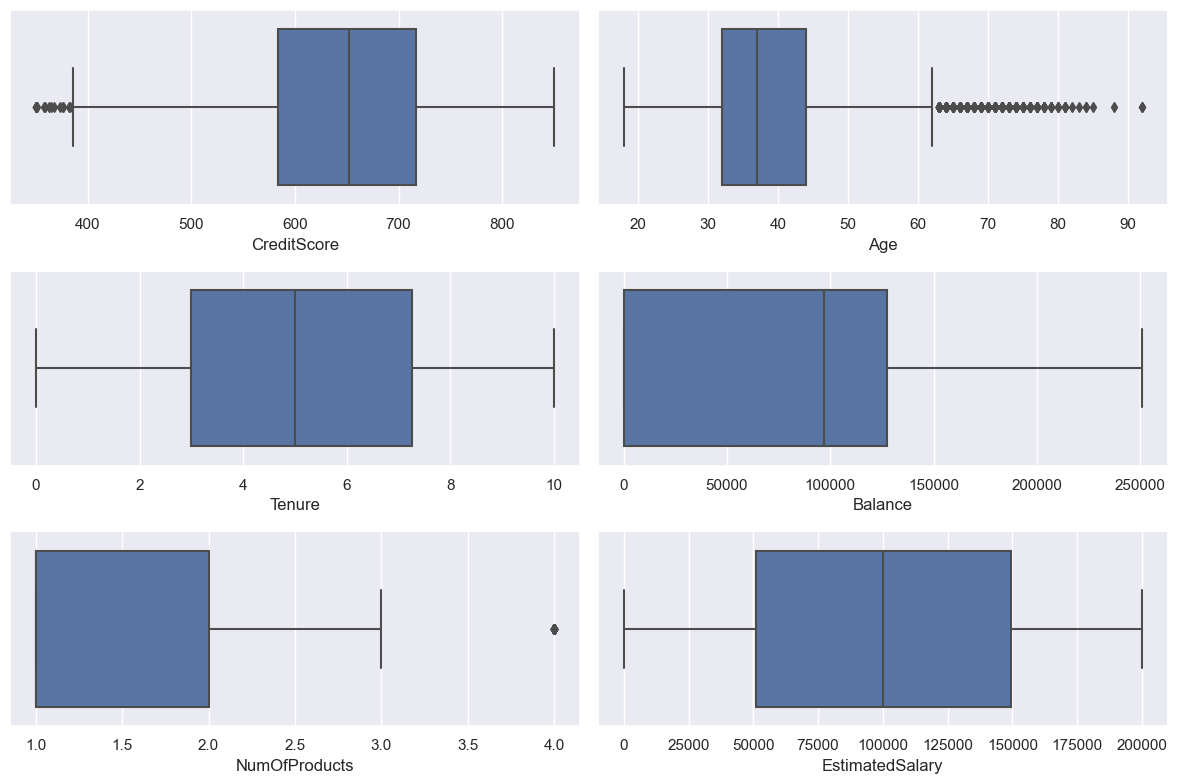

In [14]:
## Visualize distribution of numerical features with boxplots

plt.figure(figsize=(12, 8))
for i, feature in enumerate(num_features):
    plt.subplot(3, 2, i+1)
    sns.boxplot(x=X_cleaned[feature])
plt.tight_layout()
plt.show()

In [15]:
## Data scaling

standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
robust_scaler = RobustScaler()

X_cleaned['CreditScore_scaled'] = standard_scaler.fit_transform(X_cleaned[['CreditScore']])
X_cleaned['Tenure_scaled'] = minmax_scaler.fit_transform(X_cleaned[['Tenure']])
X_cleaned['NumOfProducts_scaled'] = minmax_scaler.fit_transform(X_cleaned[['NumOfProducts']])
X_cleaned['EstimatedSalary_scaled'] = minmax_scaler.fit_transform(X_cleaned[['EstimatedSalary']])

# Features with outliers or skewed data
X_cleaned['Age_scaled'] = robust_scaler.fit_transform(X_cleaned[['Age']])
X_cleaned['Balance_scaled'] = robust_scaler.fit_transform(X_cleaned[['Balance']])

# Drop columns
X_cleaned.drop(columns = ['CreditScore', 'Tenure', 'NumOfProducts', 'EstimatedSalary', 'Age', 'Balance'], inplace = True)
X_cleaned.head(10)

,HasCrCard,IsActiveMember,Surname_encoded,Geography_Germany,Geography_Spain,Gender_Male,CreditScore_scaled,Tenure_scaled,NumOfProducts_scaled,EstimatedSalary_scaled,Age_scaled,Balance_scaled
0,1.0,1.0,0.307376,0,0,0,-0.326054,0.2,0.000000,0.506735,0.416667,-0.761311
1,0.0,1.0,0.167126,0,1,0,-0.439902,0.1,0.000000,0.562709,0.333333,-0.104712
2,1.0,0.0,0.214480,0,0,0,-1.536986,0.8,0.666667,0.569654,0.416667,0.489563
3,0.0,0.0,0.207504,0,0,0,0.501933,0.1,0.333333,0.469120,0.166667,-0.761311
5,1.0,0.0,0.166713,0,1,1,-0.056958,0.8,0.333333,0.748797,0.583333,0.129917
7,1.0,0.0,0.245800,1,0,0,-2.841066,0.4,1.000000,0.596733,-0.666667,0.140031
10,0.0,0.0,0.177268,0,0,1,-1.267890,0.6,0.333333,0.400886,-0.500000,0.037946
11,1.0,0.0,0.163470,0,1,1,-1.588735,0.3,0.333333,0.381929,-1.083333,-0.761311
12,1.0,0.0,0.166607,0,0,0,-1.806082,1.0,0.333333,0.131260,-0.250000,-0.761311
13,0.0,0.0,0.197248,0,0,0,-1.050543,0.5,0.333333,0.954322,-1.000000,-0.761311


### 3.5 Feature correlation
Feature correlation is evaluated here in order to determine whether there are highly correlated features and if certain features should be removed.

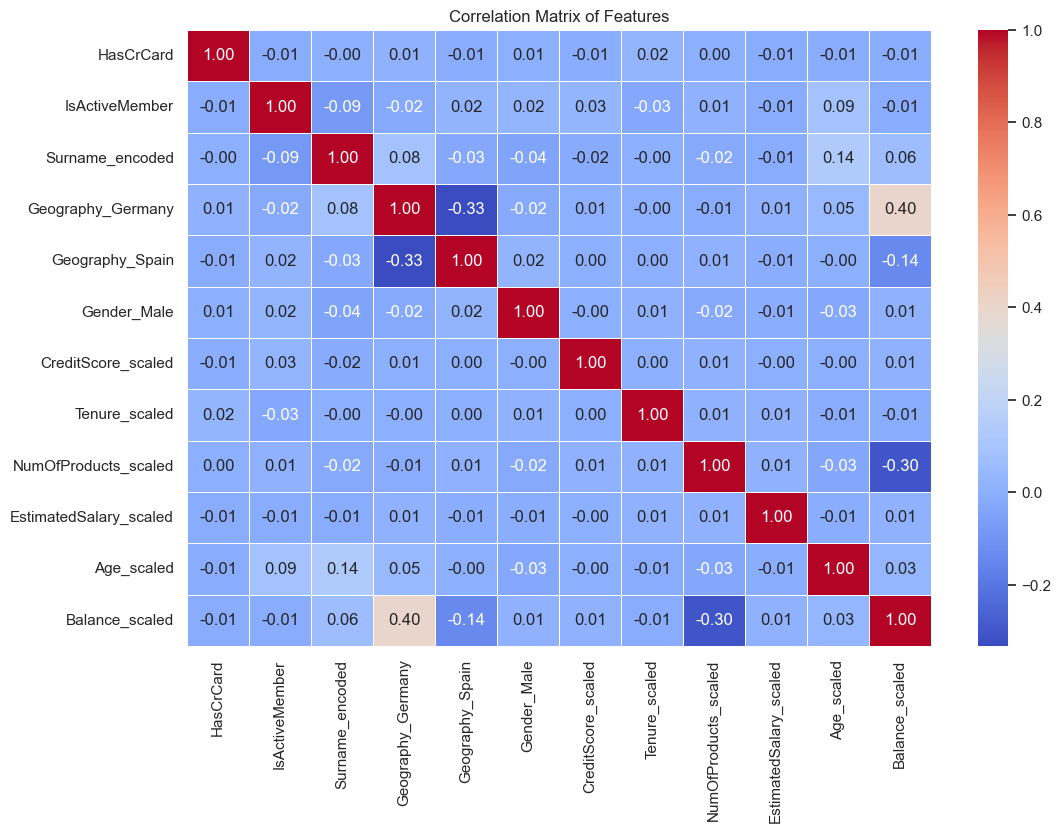

There are no highly correlated feature pairs.


In [16]:
##  visualize correlation matrix

corr_matrix = X_cleaned.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()

high_corr_pairs = corr_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates()
high_corr_pairs = high_corr_pairs[(high_corr_pairs != 1) & (high_corr_pairs > 0.8)]

if high_corr_pairs.empty:
    print("There are no highly correlated feature pairs.")
else:
    print("Highly correlated feature pairs:\n", high_corr_pairs)

### 3.6 Data cleaning and preprocessing summary

The dataset contains a very small percentage of missing value and duplicates, therefore these were removed. For encoding, two different encoders were applied: one-hot encoder for features with low cardinality and target encoder for features with high cardinality. The scaling was performed based on the data distribution of numerical features. The evaluation on feature correlation matrix showed that no highly correlated feature pairs were identified, indicating that there are no features to be removed. Through these steps, the dataset was cleaned and preprocessed for further analysis.



## 4. Model and analysis
A baseline model using random forest classifier was trained and intial results were compared. Based on the results, further model optimization was performed through grid search on four different models.

### 4.1 Baseline model

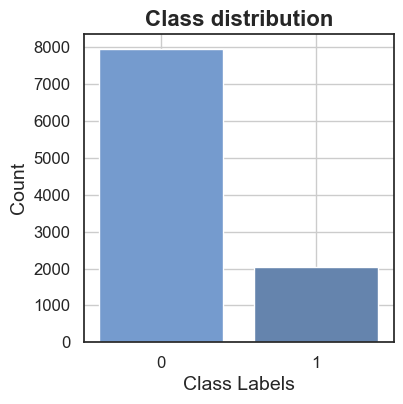

In [17]:
# check the target data

palette = sns.dark_palette("#69d", reverse=True)
plt.figure(figsize=(4, 4))
sns.set_style("white")
sns.countplot(x=y, palette=palette)
plt.title('Class distribution', fontsize=16, fontweight='bold')
plt.xlabel('Class Labels', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.show()

#### 4.1.1 Try model with Random forest classifier without SMOTE

SMOTE is used to balance the distribution of target data.

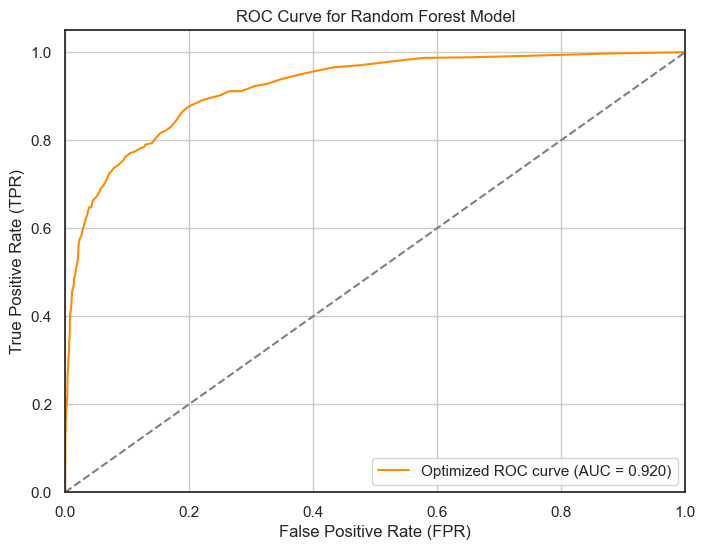

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      2389
           1       0.83      0.62      0.71       610

    accuracy                           0.90      2999
   macro avg       0.87      0.79      0.82      2999
weighted avg       0.89      0.90      0.89      2999



In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, test_size=0.3, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'Optimized ROC curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Random Forest Model')
plt.legend(loc='lower right')
plt.grid()
sns.set_style("white")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))

#### 4.1.2 Try Random forest model with SMOTE

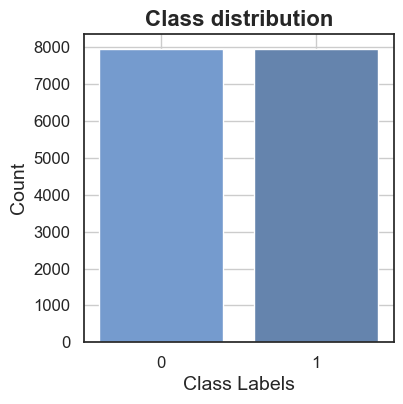

In [19]:
smote = SMOTE(random_state=42, sampling_strategy='minority')
X_resampled, y_resampled = smote.fit_resample(X_cleaned, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

palette = sns.dark_palette("#69d", reverse=True)
plt.figure(figsize=(4, 4))
sns.set_style("white")
sns.countplot(x=y_resampled, palette=palette)
plt.title('Class distribution', fontsize=16, fontweight='bold')
plt.xlabel('Class Labels', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.show()

Random Forest AUC: 0.974


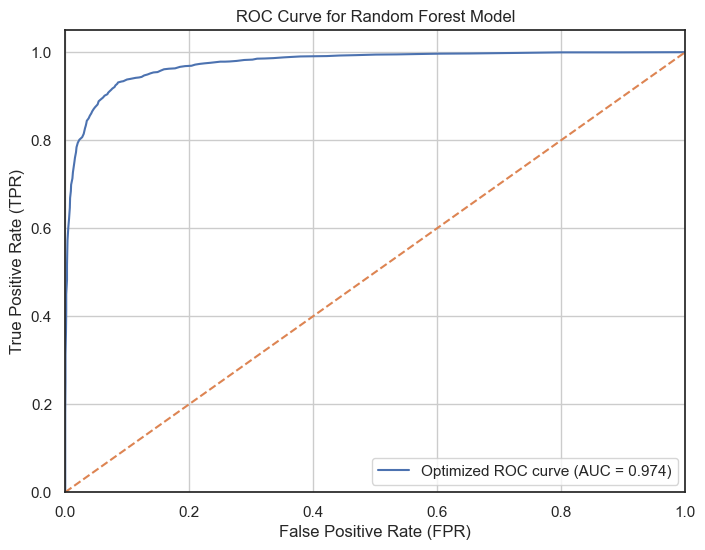

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      2410
           1       0.92      0.92      0.92      2366

    accuracy                           0.92      4776
   macro avg       0.92      0.92      0.92      4776
weighted avg       0.92      0.92      0.92      4776



In [20]:
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
print(f'Random Forest AUC: {auc:.3f}')

plt.figure(figsize=(8, 6))
sns.set_style("white")
plt.plot(fpr, tpr, label=f'Optimized ROC curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Random Forest Model')
plt.legend(loc='lower right')
plt.grid()
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))

#### 4.1.3 Feature importance evaluation

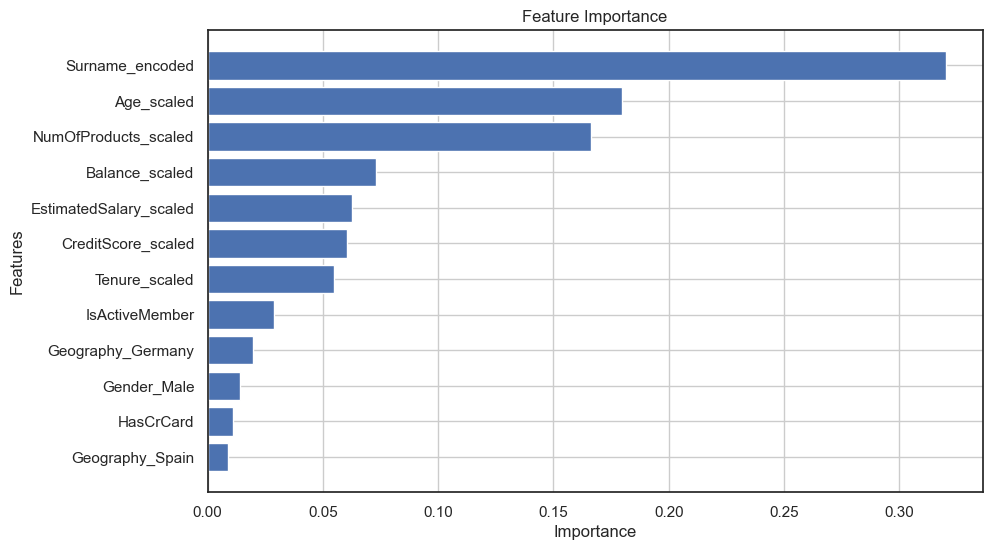

In [21]:
# check feature importance

feature_importance = rf_model.feature_importances_
feature_names = X_resampled.columns
df_importances = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
df_importances = df_importances.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
sns.set_style("white")
plt.barh(df_importances['Feature'], df_importances['Importance'])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.grid()
plt.show()


Number of Features: 1, AUC: 0.943
Number of Features: 2, AUC: 0.935
Number of Features: 3, AUC: 0.950
Number of Features: 4, AUC: 0.958
Number of Features: 5, AUC: 0.960
Number of Features: 6, AUC: 0.961
Number of Features: 7, AUC: 0.964
Number of Features: 8, AUC: 0.968
Number of Features: 9, AUC: 0.971
Number of Features: 10, AUC: 0.972
Number of Features: 11, AUC: 0.973
Number of Features: 12, AUC: 0.974


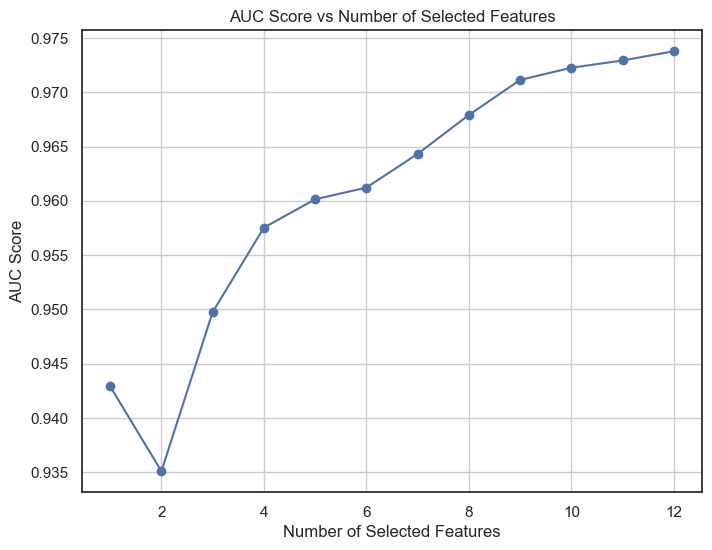

In [22]:
## Compare RFE

num_features_list = []
scores = []

rf_model = RandomForestClassifier(random_state=42)

for num_features in range(1, X_train.shape[1] + 1):
    rfe = RFE(estimator=rf_model, n_features_to_select=num_features)
    rfe.fit(X_train, y_train)

    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)
    rf_model.fit(X_train_rfe, y_train)

    y_pred_proba_rfe = rf_model.predict_proba(X_test_rfe)[:, 1]
    auc_rfe = roc_auc_score(y_test, y_pred_proba_rfe)

    num_features_list.append(num_features)
    scores.append(auc_rfe)
    print(f'Number of Features: {num_features}, AUC: {auc_rfe:.3f}')

plt.figure(figsize=(8, 6))
plt.plot(num_features_list, scores, marker='o')
plt.xlabel('Number of Selected Features')
plt.ylabel('AUC Score')
plt.title('AUC Score vs Number of Selected Features')
plt.grid()
plt.show()

Number of features beyond 9 does not significantly improve the AUC score, however there is still slight improvement. 

### 4.2 Model optimization and comparison

**The following models are compared:**
- **Logistic regression**
- **Random forest classifier**
- **Gradient boosting classifier**
- **SVM**

In [23]:
# Initialize the models
lr = LogisticRegression(class_weight='balanced', random_state=42)
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
gb = GradientBoostingClassifier(random_state=42)
svm = SVC(probability=True, random_state=42)

# define parameter grids for different models
param_lr = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear']
}

param_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
    'model__bootstrap': [True, False]
}

param_gb = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [3, 4],
    'model__min_samples_split': [2, 5]
}

param_svm = {
    'model__C': [0.1, 1, 10, 100],
    'model__kernel': ['linear', 'rbf', 'poly'],
    'model__gamma': ['scale', 'auto']
}


models = {
    'Logistic Regression': (lr, param_lr),
    'Random Forest': (rf, param_rf),
    'Gradient Boosting': (gb, param_gb),
    'SVM': (svm, param_svm),
}

## Calculate best auc_score for each model
auc_scores = {}

for model_name, (model, param) in models.items():
    pipeline = Pipeline([('model', model)])
    grid_search = GridSearchCV(pipeline, param_grid=param, cv=3, verbose=2, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    auc_scores[model_name] = roc_auc_score(y_test, y_pred_proba)
    print(f'{model_name} AUC: {auc:.3f}')

auc_results = pd.DataFrame(list(auc_scores.items()), columns=['Model', 'AUC Score'])


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END model__C=0.01, model__penalty=l1, model__solver=liblinear; total time=   0.0s
[CV] END model__C=0.01, model__penalty=l1, model__solver=liblinear; total time=   0.0s
[CV] END model__C=0.01, model__penalty=l1, model__solver=liblinear; total time=   0.0s
[CV] END model__C=0.01, model__penalty=l2, model__solver=liblinear; total time=   0.0s
[CV] END model__C=0.1, model__penalty=l2, model__solver=liblinear; total time=   0.0s
[CV] END model__C=0.01, model__penalty=l2, model__solver=liblinear; total time=   0.0s
[CV] END model__C=0.01, model__penalty=l2, model__solver=liblinear; total time=   0.0s
[CV] END model__C=0.1, model__penalty=l1, model__solver=liblinear; total time=   0.1s
[CV] END model__C=0.1, model__penalty=l2, model__solver=liblinear; total time=   0.0s
[CV] END model__C=0.1, model__penalty=l2, model__solver=liblinear; total time=   0.0s
[CV] END model__C=1, model__penalty=l2, model__solver=liblinear; total tim


AUC Scores for Different Models:
+----+---------------------+-------------+
|    | Model               |   AUC Score |
+====+=====================+=============+
|  0 | Logistic Regression |    0.876523 |
+----+---------------------+-------------+
|  1 | Random Forest       |    0.976947 |
+----+---------------------+-------------+
|  2 | Gradient Boosting   |    0.978264 |
+----+---------------------+-------------+
|  3 | SVM                 |    0.94197  |
+----+---------------------+-------------+


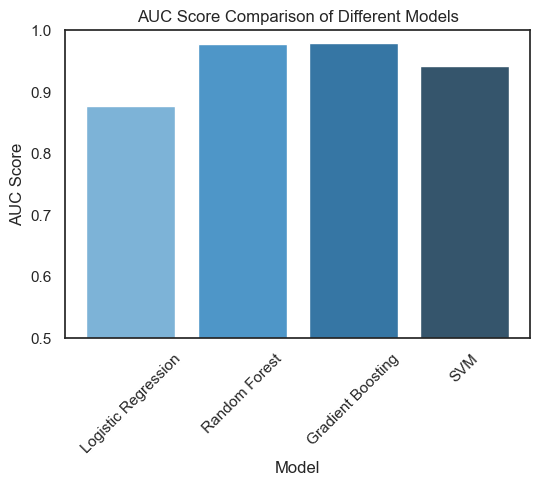

In [24]:
# Print the AUC table
print("\nAUC Scores for Different Models:")
print(tabulate(auc_results, headers='keys', tablefmt='grid'))

# Plot AUC scores
plt.figure(figsize=(6, 4))
colors = sns.color_palette("Blues_d", len(auc_scores))
plt.bar(auc_scores.keys(), auc_scores.values(), color=colors)
plt.xlabel('Model')
plt.ylabel('AUC Score')
plt.title('AUC Score Comparison of Different Models')
plt.ylim([0.5, 1.0])
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

### 5. Result Discussion and Conclusion

This binary classification project is based on the dataset with a moderate number of rows and a manageable number of features. Therefore, a few models have been selected for evaluation, including **Logistic Regression**, **Random Forest**, **Gradient Boosting**, and **SVM**.

To compare the performances of these models, **AUC score** is selected as the primary metric due to its suitability for binary classification problems. The models are trained and hyperparameters are tuned using **grid search** to ensure optimal performance. The results show that **Gradient Boosting** and **Random Forest** outperform the others.

**Gradient Boosting** performs slightly better than **Random Forest**, achieving the best AUC score. **SVM** also delivered solid performance, though the AUC score is lower than the two tree-based models. **Logistic Regression**, however had the lowest performance, suggesting that the relationships in this dataset may not be well captured by a linear model.

To conclude, **Gradient Boosting** is the most effective model for predicting customer churn, achieving an AUC score of **0.978**, making it the top choice for this classification task.

